In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import cmath
from scipy import signal

In [2]:
# routines
def _shift(pair,shift):
    """shift t1 shift/2 samples to the left and
       shift t2 shift/2 samples to the right,
       if shift is odd move t1 the extra sample
       this process truncates trace length"""
    if shift == 0:
        return pair
    elif shift == 1:
        t1 = pair[0,:]
        t2 = pair[1,:]
        return np.vstack((t1[math.ceil(shift/2):], t2[:-shift]))
    else:
        t1 = pair[0,:]
        t2 = pair[1,:]
        return np.vstack((t1[math.ceil(shift/2):-math.floor(shift/2)], t2[:-shift]))

def _rotate(pair,degrees):
    """t1 is x-axis and t2 is y-axis,
       rotates clockwise"""
    ang = np.deg2rad(degrees)
    rot = np.array([[np.cos(ang),-np.sin(ang)],
                    [np.sin(ang), np.cos(ang)]])
    return np.dot(rot,pair)

def _rotate_and_shift(pair,degrees,shift):
    return _shift(_rotate(pair,degrees), shift)

def _split(pair,degrees,shift):
    return _rotate(_shift(_rotate(pair,degrees), shift),-degrees)

def _unsplit(pair,degrees,shift):
    return _split(pair,degrees+90,shift)
    
def _taper(pair,width,centre=None):
    """Apply Hanning window about c0 sample
       of width number of samples, truncates traces"""
    
    if centre is None:
        centre = math.floor(pair.shape[1]/2)
        
    if width > pair.shape[1]:
        raise Exception('taper width is greater than trace length')
        
    t0 = centre - math.floor(width/2)
    t1 = centre + math.ceil(width/2)
    
    if t0 < 0:
        raise Exception('window starts before trace data')
    elif t1 > pair.shape[1]:
        raise Exception('window ends after trace data')
        
    return np.hanning(width) * pair[:,t0:t1]

def _eigcov(pair):
    return np.sort(np.linalg.eigvals(np.cov(pair,rowvar=True)))
#     return np.sort(np.linalg.eigvals(np.cov(pair)))

def _grideigcov(pair,maxshift,window=None, stepang=None,stepshift=None):
    
    # set some defaults
    if stepshift is None:
        stepshift = int(np.max([1,maxshift/40]))
    if stepang is None:
        stepang = 2
    if window is None:
        # by default whatevers smaller,
        # half trace length or 10 * max shift
        window = int(np.min([pair.shape[1] * 0.5,maxshift * 10]))
    
    deg, shift = np.meshgrid(np.arange(0,180,stepang),
                             np.arange(0,maxshift,stepshift).astype(int))
    
    shape = deg.shape
    lam1 = np.zeros(shape)
    lam2 = np.zeros(shape)
    for ii in np.arange(shape[1]):
        temp = _rotate(pair,deg[0,ii]+90)
        for jj in np.arange(shape[0]):
            temp2 = _shift(temp,shift[jj,ii])
            temp3 = _taper(temp2,window)
            lam2[jj,ii], lam1[jj,ii] = _eigcov(temp3)
    return deg, shift, lam1, lam2

def _xcorr(pair):
    return np.correlate(pair[0,:],pair[1,:])[0]

def _gridxcorr(pair,maxshift,window=None, stepang=None,stepshift=None):
    
    # set some defaults
    if stepshift is None:
        stepshift = int(np.max([1,maxshift/40]))
    if stepang is None:
        stepang = 2
    if window is None:
        # by default whatevers smaller,
        # half trace length or 10 * max shift
        window = int(np.min([pair.shape[1] * 0.5,maxshift * 10]))
        
    deg, shift = np.meshgrid(np.arange(0,180,stepang),
                             np.arange(0,maxshift,stepshift).astype(int))
    
    shape = deg.shape
    xc = np.zeros(shape)
    for ii in np.arange(shape[1]):
        temp = _rotate(pair,deg[0,ii]+90)
        for jj in np.arange(shape[0]):
            temp2 = _shift(temp,shift[jj,ii])
            temp3 = _taper(temp2,window)
            xc[jj,ii] = _xcorr(temp3)
    return deg, shift, xc 

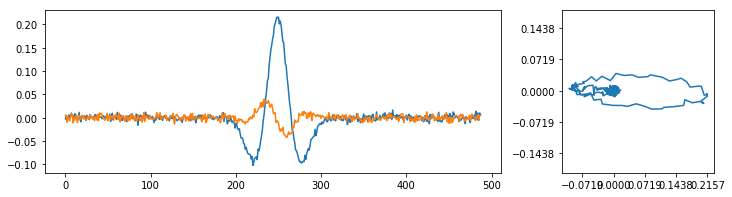

In [3]:
# synthetic data
ricker = signal.ricker(500, 16.0)
pair = np.vstack((ricker,np.zeros(ricker.shape)))
noise = np.random.normal(0,.005,pair.shape)
splitdata = _split(pair+noise,110,12)

def plt_pair(pair):
    from matplotlib import gridspec
    fig = plt.figure(figsize=(12, 3)) 
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    ax0 = plt.subplot(gs[0])
    ax0.plot(pair.T)
    ax1 = plt.subplot(gs[1])
    ax1.plot(pair[0,:],pair[1,:])
    ticks = np.linspace(-np.abs(pair).max(),np.abs(pair).max(),7)
    ax1.xaxis.set_ticks(ticks)
    ax1.yaxis.set_ticks(ticks)
    plt.axis('equal')
    plt.show()
    
plt_pair(splitdata)

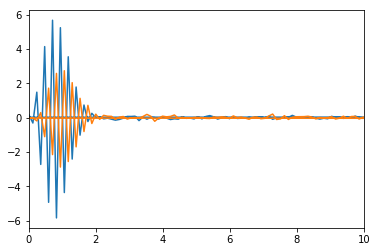

In [4]:
t1 = splitdata[0,:]
sp = np.fft.fft(t1)
freq = np.rad2deg(np.fft.fftfreq(t1.shape[-1]))
plt.plot(freq, sp.real, freq, sp.imag)
plt.xlim(0,10)
plt.show()

In [5]:
np.fft.fft?

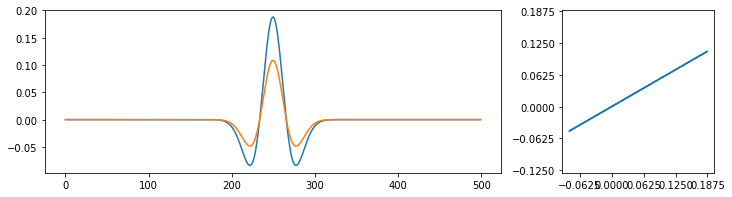

In [6]:
plt_pair(_rotate(pair,30))

In [7]:
f1 = np.fft.fft(pair[0,:])
f2 = np.fft.fft(pair[1,:])

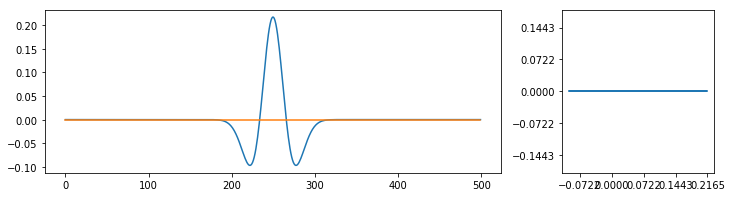

In [8]:
# Forward and reverse Fourier Transform
plt_pair(np.vstack((np.real(np.fft.ifft(f1)),
                            np.real(np.fft.ifft(f2)))))

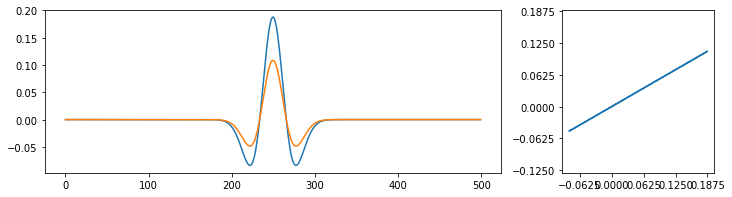

In [9]:
# Rotation in Fourier Domain
rf = _rotate(np.vstack((f1,f2)),30)
data = np.vstack((np.real(np.fft.ifft(rf[0,:])),
                  np.real(np.fft.ifft(rf[1,:]))))
plt_pair(data)

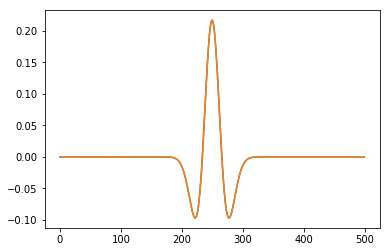

In [10]:
# Shift in the Fourier Domain
# t1 = _taper(splitdata,100)[0,:]
t1 = pair[0,:]
f1 = np.fft.fft(t1)
delta = 1
# shift must be an integer multiple of delta
shift = 0
N = f1.size
P = np.arange(N) * -(2*np.pi * shift)/(delta * N)  
fs = f1 * np.exp(1j*P)
t2 = np.real(np.fft.ifft(fs))
plt.plot(t1)
plt.plot(t2)
# plt.plot(fs.real)
# plt.plot(fs.imag)
# freq = np.rad2deg(np.fft.fftfreq(t1.shape[-1]))
# plt.plot(freq, f1.real, freq, f1.imag)
# plt.xlim(0,4)
# plt.show()


In [11]:
# a = np.array([1,2])
b = np.array([np.pi,np.pi/2])
np.cos(b) + np.sin(b)*1j

array([ -1.00000000e+00 +1.22464680e-16j,   6.12323400e-17 +1.00000000e+00j])

In [12]:
np.cov(t1,t2)

array([[ 0.00200401,  0.00200401],
       [ 0.00200401,  0.00200401]])

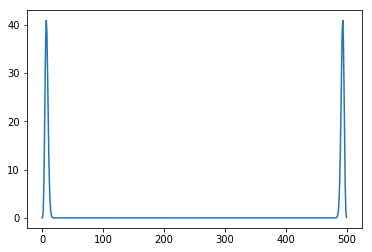

In [13]:
plt.plot(np.abs(f1)**2)

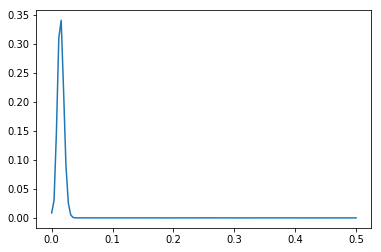

In [14]:
from scipy.signal import welch
f, psd = welch(splitdata[0,:],
               fs=1.,  # sample rate
               window='hanning',   # apply a Hanning window before taking the DFT
               nperseg=256,        # compute periodograms of 256-long segments of x
               detrend='constant') # detrend x by subtracting the mean
plt.plot(f,psd)

In [2]:
import splitwavepy as sw

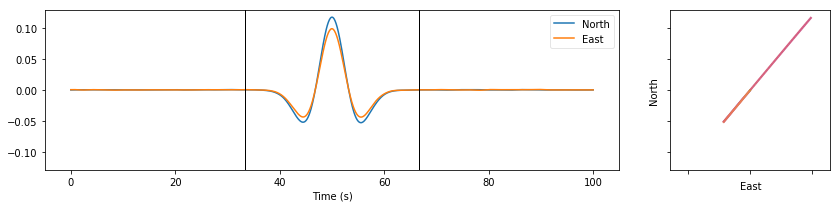

In [3]:
a = sw.SplitWave(pol=40)
a.plot()

In [4]:
# get fourier traces
x = a.x[:-1]
y = a.y[:-1]
x = x - np.mean(x)
y = y - np.mean(y)
fx = np.fft.rfft(x)
fy = np.fft.rfft(y)

In [5]:
# cross correlation (in Fourier domain)
cxy = fx*fy.conj()
cyx = fy*fx.conj()
cxx = fx*fx.conj()
cyy = fy*fy.conj()

In [6]:
# reverse transform cross-correlation
ixy = np.fft.irfft(cxy)
iyx = np.fft.irfft(cyx)
ixx = np.fft.irfft(cxx)
iyy = np.fft.irfft(cyy)

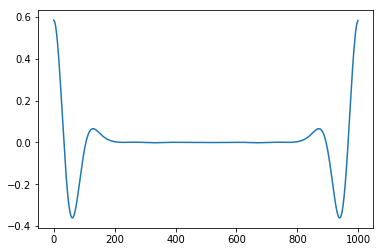

In [7]:
# plt.plot(np.real(ixx))
# plt.plot(np.real(iyy))
plt.plot(ixx)

0.49034212114277587

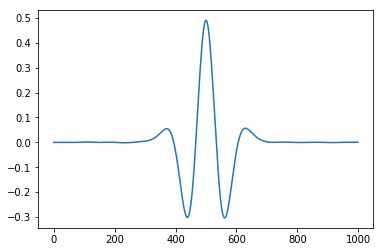

In [8]:
plt.plot(np.correlate(x,y,mode='same'))
np.max(np.correlate(x,y,mode='same'))

In [9]:
# raw correlation coefficient difference between
# fourier method V time domain method
ixy[0] - np.correlate(x,y)

array([ -1.66533454e-16])

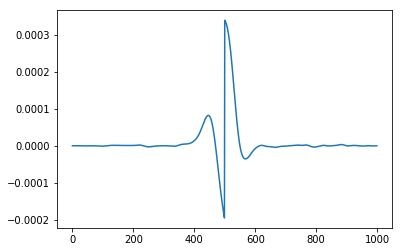

In [10]:
corrxy = np.correlate(x,y,'same')
mid = int(x.size/2)
plt.plot(ixy - np.roll(corrxy,mid))
plt.show()

In [11]:
# Pearson Correlation in time domain
np.correlate(x, y)/(x.size * np.std(x) * np.std(y)) - np.corrcoef(x, y)[0,1]

array([  2.22044605e-16])

In [12]:
np.var(x) - ixx[0] / x.size

1.0842021724855044e-19

In [13]:
stdx = np.sqrt( ixx[0]/ x.size)
stdy = np.sqrt( iyy[0]/ y.size)

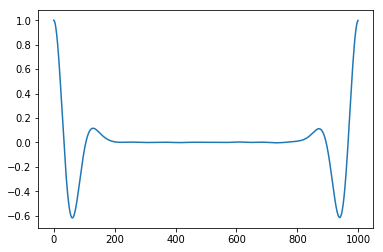

In [14]:
# plt.plot(ixx)
plt.plot(ixy / (x.size * stdx * stdy))

In [15]:
ixy.real / ixy.size

array([  4.90342121e-04,   4.89763247e-04,   4.87989079e-04,
         4.85025568e-04,   4.80882721e-04,   4.75574560e-04,
         4.69119064e-04,   4.61538085e-04,   4.52857257e-04,
         4.43105887e-04,   4.32316821e-04,   4.20526309e-04,
         4.07773844e-04,   3.94101996e-04,   3.79556225e-04,
         3.64184690e-04,   3.48038042e-04,   3.31169213e-04,
         3.13633187e-04,   2.95486775e-04,   2.76788377e-04,
         2.57597738e-04,   2.37975706e-04,   2.17983984e-04,
         1.97684880e-04,   1.77141058e-04,   1.56415291e-04,
         1.35570216e-04,   1.14668092e-04,   9.37705634e-05,
         7.29384272e-05,   5.22314100e-05,   3.17079508e-05,
         1.14249930e-05,  -8.56221406e-06,  -2.82003027e-05,
        -4.74379640e-05,  -6.62261126e-05,  -8.45180394e-05,
        -1.02269551e-04,  -1.19439094e-04,  -1.35987871e-04,
        -1.51879936e-04,  -1.67082276e-04,  -1.81564887e-04,
        -1.95300822e-04,  -2.08266234e-04,  -2.20440403e-04,
        -2.31805748e-04,

In [16]:
ixx.real[0]

0.58521191677769779

In [17]:
np.correlate(a.x, a.x)

array([ 0.58521198])

In [18]:
np.var(a.x)*(a.x.size)

0.5852119248656189

In [19]:
np.abs(ixx)

array([  5.85211917e-01,   5.84497536e-01,   5.82356840e-01,
         5.78797145e-01,   5.73830614e-01,   5.67474198e-01,
         5.59749561e-01,   5.50682988e-01,   5.40305266e-01,
         5.28651550e-01,   5.15761213e-01,   5.01677666e-01,
         4.86448180e-01,   4.70123675e-01,   4.52758501e-01,
         4.34410211e-01,   4.15139310e-01,   3.95009002e-01,
         3.74084924e-01,   3.52434872e-01,   3.30128516e-01,
         3.07237118e-01,   2.83833237e-01,   2.59990439e-01,
         2.35782993e-01,   2.11285586e-01,   1.86573020e-01,
         1.61719927e-01,   1.36800476e-01,   1.11888098e-01,
         8.70552057e-02,   6.23729285e-02,   3.79108562e-02,
         1.37367907e-02,   1.00834895e-02,   3.34864528e-02,
         5.64110243e-02,   7.87987824e-02,   1.00594140e-01,
         1.21744508e-01,   1.42200451e-01,   1.61915815e-01,
         1.80847845e-01,   1.98957288e-01,   2.16208473e-01,
         2.32569375e-01,   2.48011667e-01,   2.62510747e-01,
         2.76045754e-01,

In [20]:
rotate = sw.core.core.rotate

def gridcov(x, y, w0, w1, degs, slags):
    # prepare empty covariance arrays
    g = np.empty((degs.size, slags.size, 2, 2))
    n = w1 - w0
    npsum = np.sum # remove dots from inner loop
    # now loop and calculate
    for ii in range(degs.size):
        # prepare a list of data rotated to degs
        rot = rotate(x, y, degs[ii])
        # this is the mean in each window
        meanx = running_mean(rot[0], w0, w1, slags)
        meany = running_mean(rot[1], w0, w1, slags)
        # loop over lags
        for jj in range(slags.size):
            slag = slags[jj]
            wx, wy  = slagchop(rot[0], rot[1], w0, w1, -slag)
            dx, dy = wx - meanx[slag], wy - meany[slag]
            g[ii, jj, 0, 0] = npsum(dx * dx)
            g[ii, jj, 1, 0] = g[ii, jj, 0, 1] = npsum(dx * dy)
            g[ii, jj, 1, 1] = npsum(dy * dy)
    return g / n
    

In [21]:
rotate = sw.core.core.rotate

def gridcovfreq(x, y, ndegs=60, nlags=50):
    """Returns grid of covariance matrices of shape (ndegs/2, 1+2*nlags, 2, 2).
       The grid contains 
    """
    mdegs = int(ndegs/2)
    mlags = int(nlags*2) + 1
    degs = np.linspace(0, 90, mdegs, endpoint=False)
    n = x.size
    g = np.empty((mlags, mdegs, 2, 2))
    # Fourier Transform
    x = x - np.mean(x)
    y = y - np.mean(y)
    fx = np.fft.rfft(x)
    fy = np.fft.rfft(y)    
    # now loop and calculate
    for ii in range(mdegs):
        # rotate
        fxr, fyr = rotate(fx, fy, degs[ii])
        # correlate
        cxx = fxr * fxr.conj()
        cyy = fyr * fyr.conj()
        cxy = fxr * fyr.conj()
        # inverse transform
        icxx = np.fft.irfft(cxx) 
        icyy = np.fft.irfft(cyy)
        icxy = np.fft.irfft(cxy)
        # get info
        varx = icxx[0]
        vary = icyy[0]
        rho = np.roll(icxy, int(nlags))[0:mlags]
        # basic covariance map
        g[:,ii,0,0] = varx
        g[:,ii,1,1] = vary
        g[:,ii,0,1] = g[:,ii,1,0] = rho
    return g / n 
    

In [22]:
a = sw.SplitWave(pol=0, split=(30,2), noise=0.02)
x = a.x[:-1]
y = a.y[:-1]
cov = gridcovfreq(x,y)
# xx,yy = np.meshgrid(np.arange(90), np.arange(a.x.size-1))
# plt.contourf(xx,yy,cov.T,30,cmap='magma')
# plt.show()

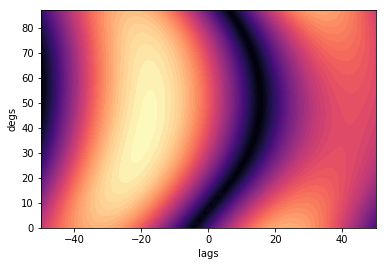

In [23]:
yy = np.linspace(0, 90, cov.shape[1], endpoint=False)
mlags = cov.shape[0]
maxlag = (mlags - 1)/2
xx = np.linspace(-maxlag, maxlag, mlags)
xx, yy = np.meshgrid(xx, yy, indexing='ij')
plt.ylabel('degs')
plt.xlabel('lags')
rho = sw.core.core.covmap2rho(cov)
plt.contourf(xx, yy, abs(rho), 50, cmap='magma')
plt.show()

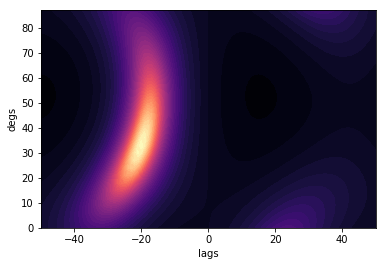

In [24]:
yy = np.linspace(0, 90, cov.shape[1], endpoint=False)
mlags = cov.shape[0]
maxlag = (mlags - 1)/2
xx = np.linspace(-maxlag, maxlag, mlags)
xx, yy = np.meshgrid(xx, yy, indexing='ij')
plt.ylabel('degs')
plt.xlabel('lags')
lam1, lam2 = sw.core.core.covmap2eigvals(cov)
plt.contourf(xx, yy, lam1/lam2, 50, cmap='magma')
plt.show()

In [25]:
neg = cov[:51,:,:,:]
pos = cov[50:,:,:,:]

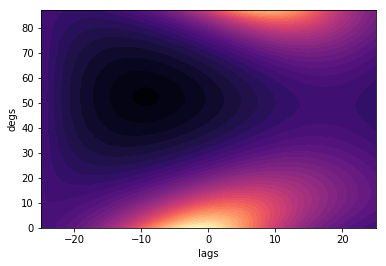

In [26]:
# plot positive lags (from the right)
yy = np.linspace(0, 90, pos.shape[1], endpoint=False)
mlags = pos.shape[0]
maxlag = (mlags - 1)/2
xx = np.linspace(-maxlag, maxlag, mlags)
xx, yy = np.meshgrid(xx, yy, indexing='ij')
plt.ylabel('degs')
plt.xlabel('lags')
lam1, lam2 = sw.core.core.covmap2eigvals(pos)
plt.contourf(xx,yy,lam1/lam2,50,cmap='magma')

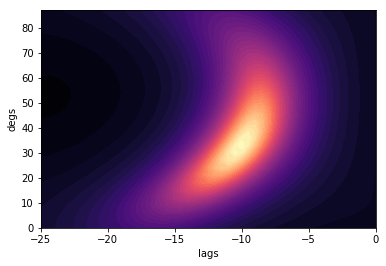

In [27]:
# plot negative lags (from the left)
yy = np.linspace(0, 90, neg.shape[1], endpoint=False)
mlags = neg.shape[0]
maxlag = (mlags - 1)/2
xx = np.linspace(-maxlag, 0, mlags)
xx, yy = np.meshgrid(xx, yy, indexing='ij')
plt.ylabel('degs')
plt.xlabel('lags')
lam1, lam2 = sw.core.core.covmap2eigvals(neg)
plt.contourf(xx,yy,lam1/lam2,50,cmap='magma')

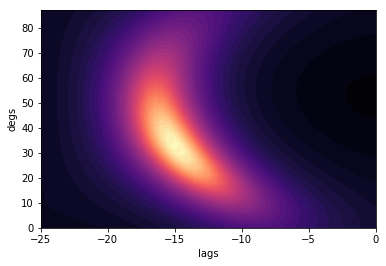

In [28]:
# flip the "negative" lags
negflip = np.flip(neg,0)
yy = np.linspace(0, 90, negflip.shape[1], endpoint=False)
mlags = negflip.shape[0]
maxlag = (mlags - 1)/2
xx = np.linspace(-maxlag, 0, mlags)
xx, yy = np.meshgrid(xx, yy, indexing='ij')
plt.ylabel('degs')
plt.xlabel('lags')
lam1, lam2 = sw.core.core.covmap2eigvals(negflip)
plt.contourf(xx,yy,lam1/lam2,50,cmap='magma')

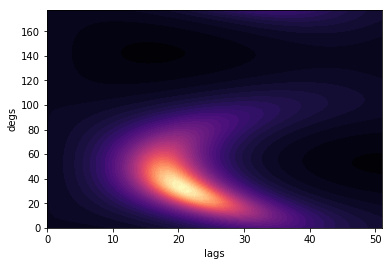

In [29]:
# concatenate lags
covcat = np.concatenate((negflip,pos),axis=1)
# plot
yy = np.linspace(0, 180, covcat.shape[1], endpoint=False)
mlags = covcat.shape[0]
# maxlag = (mlags - 1)/2
xx = np.linspace(0, mlags, mlags)
xx, yy = np.meshgrid(xx, yy, indexing='ij')
plt.ylabel('degs')
plt.xlabel('lags')
lam1, lam2 = sw.core.core.covmap2eigvals(covcat)
plt.contourf(xx, yy, lam1/lam2, 50, cmap='magma')
plt.show()

In [30]:
def freqcov_reshape(cov):
    shp = cov.shape
    mid = int((shp[0]-1)/2)
    neg = np.flip(cov[:mid+1,:,:,:], 0)
    pos = cov[mid:,:,:,:]
    return np.concatenate((neg, pos), axis=1)

In [31]:
int((cov.shape[0]-1)/2)

50

In [ ]:
def gridcovfreqwin(x, y, w0, w1, ndegs=60, nlags=50):
    """Returns grid of covariance matrices of shape (ndegs/2, 1+2*nlags, 2, 2).
       The grid contains 
    """
    mdegs = int(ndegs/2)
    mlags = int(nlags*2) + 1
    degs = np.linspace(0, 90, mdegs, endpoint=False)
    n = x.size
    g = np.empty((mlags, mdegs, 2, 2))
    # Fourier Transform
    x = x - np.mean(x)
    y = y - np.mean(y)
    fx = np.fft.rfft(x)
    fy = np.fft.rfft(y)    
    # now loop and calculate
    for ii in range(mdegs):
        # rotate
        fxr, fyr = rotate(fx, fy, degs[ii])
        # multiply by Fwindow to get running means
        # correlate
        cxx = fxr * fxr.conj()
        cyy = fyr * fyr.conj()
        cxy = fxr * fyr.conj()
        # inverse transform
        icxx = np.fft.irfft(cxx) 
        icyy = np.fft.irfft(cyy)
        icxy = np.fft.irfft(cxy)
        # get info
        varx = icxx[0]
        vary = icyy[0]
        rho = np.roll(icxy, int(nlags))[0:mlags]
        # basic covariance map
        g[:,ii,0,0] = varx
        g[:,ii,1,1] = vary
        g[:,ii,0,1] = g[:,ii,1,0] = rho
    return g / n 

Apply splitting operator in Fourier domain.

In [9]:
import splitwavepy as sw
import numpy as np
import math
import matplotlib.pyplot as plt

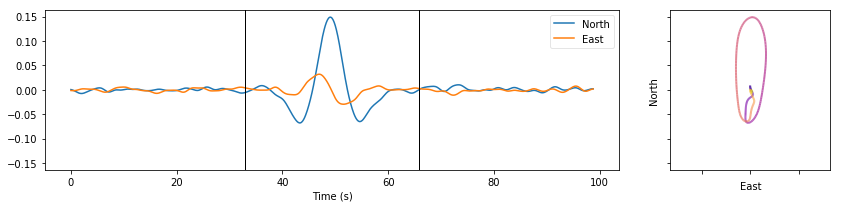

In [4]:
a = sw.SplitWave(split=(30,1.2), noise=0.02)
a.plot()

In [13]:
def split_operator(phi, slag):
    # rotate:
    ang = math.radians(phi)
    cang = math.cos(ang)
    sang = math.sin(ang)
    rot = np.array([[ cang, sang],
                    [-sang, cang]])
    # lag:
    pi = math.pi
    p = -(2*pi * slag)
    q = np.exp(1j*p)
    lag = q * np.eye(2)
    return rot + lag
#     return np.dot()

def splitting_in_fourier(x, y, phi, slag):
    # Fourier transform data
    fx = np.fft.rfft(x)
    fy = np.fft.rfft(y)
    data = np.vstack((fx, fy))
    gamma = split_operator(phi, slag)
    data = np.dot(gamma, data)
    x = np.fft.irfft(data[0])
    y = np.fft.irfft(data[1])
    return x, y

In [17]:
x = a.x
y = a.y
x1, y1 = splitting_in_fourier(x, y, 45, 10)

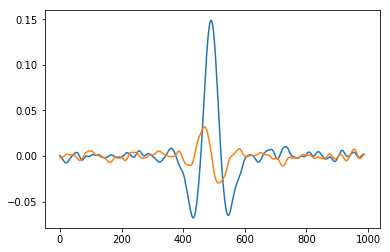

In [18]:
plt.plot(x)
plt.plot(y)
plt.show()

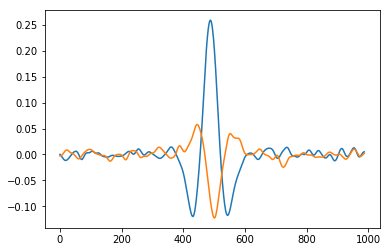

In [20]:
plt.plot(x1)
plt.plot(y1)
plt.show()

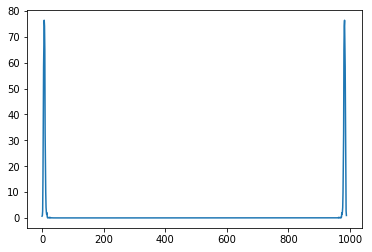

In [42]:
fx = np.fft.fft(x)
pwr = np.abs(fx)**2
plt.plot(pwr)
plt.show()

In [43]:
np.sum(x**2)

0.96067011998107343

In [44]:
np.sum(pwr)/x.size

0.96067011998107288

1.07608771453


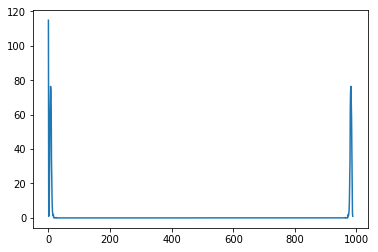

1.07608771453


In [48]:
xb = x + 0.01
print(np.sum(xb**2))
fxb = np.fft.fft(xb)
pwr = np.abs(fxb)**2
plt.plot(pwr)
plt.show()
print(np.sum(pwr)/x.size)

In [52]:
fxb[0] = 0
pwr = np.abs(fxb)**2
print(np.sum(pwr)/x.size)

0.959980456357


In [60]:
x = a.x[:-1]
x = x - np.mean(x)
fx = np.fft.fft(x)
ifx = np.fft.ifft(fx)
np.sum(x-ifx)

(-4.7933569074132439e-15+5.3248111102418297e-30j)

0.00083374789813840222

$Cov(X,Y) = E[(X-E[X])(Y-E[Y])]$

$Cov(X,Y) = E[XY] - E[X]E[Y]$

If we can guarantee $E[X]=0$ or $E[Y]=0$ ...


$Cov(X,Y) = E[XY]$

By parseval's theorem the sum $\sum{XY}$ can be calculated in the Fourier domain.

Remove the mean in the Fourier domain by setting the 0th entry to zero.

In [91]:
x = a.x[:]
# x = x - np.mean(x)
print('ener', np.sum(x**2))
# print(np.sum(x**2)/x.size)
print('var', np.var(x))

ener 0.960670119981
var 0.000970657690957


In [92]:
# Fourier transform x
fx = np.fft.fft(x)
# Remove mean
fx[0] = 0
# Calc Energy
pwr = np.abs(fx)**2
ener = np.sum(pwr)/x.size
print('ener', ener)
# Variance
print('var', ener/x.size)

ener 0.959980456357
var 0.000970657690957


In [197]:
def cov_in_fourier(x, y):
    fx = np.fft.fft(x)
    fx[0] = 0
    fy = np.fft.fft(y)
    fy[0] = 0
    n = x.size
    pwr = np.abs(fx) * np.abs(fy.conj())   
    cov = np.sum(pwr) / n**2
    return cov

In [198]:
x = a.x
y = a.y
ncov = np.cov(x, y)
ncov

array([[  9.71640138e-04,   3.51404389e-05],
       [  3.51404389e-05,   6.82963111e-05]])

In [199]:
cxx = cov_in_fourier(x, x)
cyy = cov_in_fourier(y, y)
cxy = cov_in_fourier(x, y)
cxy

0.00024125954387192833

In [200]:
cxx/cyy

14.226831902158857

In [201]:
cxxn = ncov[0][0]
cyyn = ncov[1][1]
cxxn/cyyn

14.226831902158851

In [165]:
cov_in_fourier(x,y)

0.00024150905616092253

In [356]:
x = a.x - np.mean(a.x)
y = a.y - np.mean(a.y)

sumxy = np.sum((x*y)**2)
print(sumxy)
fx = np.fft.fft(x)
fy = np.fft.fft(y)
fxy = np.fft.fft(x*y)
pwr = np.abs(fxy**2)
ener = pwr / x.size
print(np.sum(ener))
#
# fx[0] = fy[0] = 0
pwr = np.abs((fx*fy)**2)
ener = pwr / (2*math.pi*x.size**2)
print(np.sum(ener))
# np.sum(np.abs(fx)*np.abs(fy).conj())/(x.size*y.size)


0.000289981880111
0.000289981880111
0.000513214597367


In [348]:
fxs = np.fft.fftshift(fx)
fys = np.fft.fftshift(fy)
fxfy = np.convolve(fx,fy,'same')
np.sum(np.abs(fxfy))/(x.size*x.size*math.pi)

0.00025290075755254204

In [327]:
np.convolve?

In [2]:
import splitwavepy as sw
import numpy as np

In [17]:
rotate = sw.core.core.rotate

# faster covariance mapping exploiting correlation in frequency domain
def gridcovfreq(x, y, ndegs=60, maxslag=50):
    """Returns grid of covariance matrices of shape (ndegs/2, 1+2*maxslag, 2, 2).
       Use covfreq_reshape to get this into a more user friendly shape.
       x and y are the windowed traces.  
       Probably best to use a reasonably long, tapered, window as shifts
       are performed implicitly in the Frequency domain (so wrap around?).
    """
    mdegs = int(ndegs/2)
    mlags = int(maxslag*2) + 1
    degs = np.linspace(0, 90, mdegs, endpoint=False)
    n = x.size
    g = np.empty((mlags, mdegs, 2, 2))
    # Fourier Transform
    fx = np.fft.rfft(x)
    fy = np.fft.rfft(y)
    # now loop and calculate
    for ii in range(mdegs):
        # rotate
        fxr, fyr = rotate(fx, fy, degs[ii])
        # correlate
        cxx = fxr * fxr.conj()
        cyy = fyr * fyr.conj()
        cxy = fxr * fyr.conj()
        # inverse transform
        icxx = np.fft.irfft(cxx) 
        icyy = np.fft.irfft(cyy)
        icxy = np.fft.irfft(cxy)
        # get info
        varx = icxx[0]
        vary = icyy[0]
        rho = np.roll(icxy, int(maxslag))[0:mlags]
        # basic covariance map
        g[:,ii,0,0] = varx
        g[:,ii,1,1] = vary
        g[:,ii,0,1] = g[:,ii,1,0] = rho
    return g / n

def gridcovfreq2(x, y, ndegs=60, maxslag=50):
    """Returns grid of covariance matrices of shape (ndegs/2, 1+2*maxslag, 2, 2).
       Use covfreq_reshape to get this into a more user friendly shape.
       x and y are the windowed traces.  
       Probably best to use a reasonably long, tapered, window as shifts
       are performed implicitly in the Frequency domain (so wrap around?).
    """
    mdegs = int(ndegs/2)
    mlags = int(maxslag*2) + 1
    degs = np.linspace(0, 90, mdegs, endpoint=False)
    n = x.size
    g = np.empty((mlags, mdegs, 2, 2))
    # Fourier Transform
    fx = np.fft.fft(x)
    fy = np.fft.fft(y)
    fx[0] = 0
    fy[0] = 0
    # now loop and calculate
    for ii in range(mdegs):
        # rotate
        fxr, fyr = rotate(fx, fy, degs[ii])
        # correlate
        cxx = fxr * fxr.conj()
        cyy = fyr * fyr.conj()
        cxy = fxr * fyr.conj()
        # inverse transform
        icxx = np.fft.ifft(cxx).real
        icyy = np.fft.ifft(cyy).real
        icxy = np.fft.ifft(cxy).real
        # get info
        varx = icxx[0]
        vary = icyy[0]
        rho = np.roll(icxy, int(maxslag))[0:mlags]
        # basic covariance map
        g[:,ii,0,0] = varx
        g[:,ii,1,1] = vary
        g[:,ii,0,1] = g[:,ii,1,0] = rho
    return g / n

def gridcovfreq3(x, y, ndegs=60, maxslag=50):
    """Returns grid of covariance matrices of shape (ndegs/2, 1+2*maxslag, 2, 2).
       Use covfreq_reshape to get this into a more user friendly shape.
       x and y are the windowed traces.  
       Probably best to use a reasonably long, tapered, window as shifts
       are performed implicitly in the Frequency domain (so wrap around?).
    """
    mdegs = int(ndegs/2)
    mlags = int(maxslag*2) + 1
    degs = np.linspace(0, 90, mdegs, endpoint=False)
    n = x.size
    g = np.empty((mlags, mdegs, 2, 2))
    # Fourier Transform
    fx = np.fft.fft(x)
    fy = np.fft.fft(y)
    fx[0] = 0
    fy[0] = 0
    # now loop and calculate
    for ii in range(mdegs):
        # rotate
        fxr, fyr = rotate(fx, fy, degs[ii])
        # correlate
        cxy = fxr * fyr.conj()
        # inverse transform
        icxy = np.fft.ifft(cxy).real
        # get info
        varx = np.sum(np.abs(fxr)**2)/fxr.size
        vary = np.sum(np.abs(fyr)**2)/fyr.size
        rho = np.roll(icxy, int(maxslag))[0:mlags]
        # basic covariance map
        g[:,ii,0,0] = varx
        g[:,ii,1,1] = vary
        g[:,ii,0,1] = g[:,ii,1,0] = rho
    return g / n

def gridcovfreq4(x, y, ndegs=60, maxslag=50):
    """Returns grid of covariance matrices of shape (ndegs/2, 1+2*maxslag, 2, 2).
       Use covfreq_reshape to get this into a more user friendly shape.
       x and y are the windowed traces.  
       Probably best to use a reasonably long, tapered, window as shifts
       are performed implicitly in the Frequency domain (so wrap around?).
    """
    mdegs = int(ndegs/2)
    mlags = int(maxslag*2) + 1
    degs = np.linspace(0, 90, mdegs, endpoint=False)
    n = x.size
    g = np.empty((mlags, mdegs, 2, 2))
    # Fourier Transform
    fx = np.fft.fft(x)
    fy = np.fft.fft(y)
    fx[0] = 0
    fy[0] = 0
    # now loop and calculate
    for ii in range(mdegs):
        # rotate
        fxr, fyr = rotate(fx, fy, degs[ii])
        # correlate
        cxy = fxr * fyr.conj()
        # inverse transform
        icxy = np.fft.ifft(cxy).real
        # get info
        varx = np.sum(np.abs(fxr)**2)/n
        vary = np.sum(np.abs(fyr)**2)/n
        rho = np.roll(icxy, int(maxslag))[0:mlags]
        # basic covariance map
        g[:,ii,0,0] = varx
        g[:,ii,1,1] = vary
        g[:,ii,0,1] = g[:,ii,1,0] = rho
    return g / n

def gridcovfreq5(x, y, ndegs=60, maxslag=50):
    """Returns grid of covariance matrices of shape (ndegs/2, 1+2*maxslag, 2, 2).
       Use covfreq_reshape to get this into a more user friendly shape.
       x and y are the windowed traces.  
       Probably best to use a reasonably long, tapered, window as shifts
       are performed implicitly in the Frequency domain (so wrap around?).
    """
    mdegs = int(ndegs/2)
    mlags = int(maxslag*2) + 1
    degs = np.linspace(0, 90, mdegs, endpoint=False)
    n = x.size
    g = np.empty((mlags, mdegs, 2, 2))
    # Fourier Transform
    fx = np.fft.fft(x)
    fy = np.fft.fft(y)
    fx[0] = 0
    fy[0] = 0
    sumsqrs = np.sum(np.abs(fx)**2 + np.abs(fy)**2)
    # now loop and calculate
    for ii in range(mdegs):
        # rotate
        fxr, fyr = rotate(fx, fy, degs[ii])
        # correlate
        cxy = fxr * fyr.conj()
        # inverse transform
        icxy = np.fft.ifft(cxy).real
        # get info
        sumxsqr = np.sum(np.abs(fxr)**2)
        varx = sumxsqr/n
        vary = (sumsqrs-sumxsqr)/n
        rho = np.roll(icxy, int(maxslag))[0:mlags]
        # basic covariance map
        g[:,ii,0,0] = varx
        g[:,ii,1,1] = vary
        g[:,ii,0,1] = g[:,ii,1,0] = rho
    return g / n

def gridcovfreq6(x, y, ndegs=60, maxslag=50):
    """Returns grid of covariance matrices of shape (ndegs/2, 1+2*maxslag, 2, 2).
       Use covfreq_reshape to get this into a more user friendly shape.
       x and y are the windowed traces.  
       Probably best to use a reasonably long, tapered, window as shifts
       are performed implicitly in the Frequency domain (so wrap around?).
    """
    mdegs = int(ndegs/2)
    mlags = int(maxslag*2) + 1
    degs = np.linspace(0, 90, mdegs, endpoint=False)
    n = x.size
    g = np.empty((mlags, mdegs, 2, 2))
    # Fourier Transform
    fx = np.fft.rfft(x)
    fy = np.fft.rfft(y)
    fx[0] = 0
    fy[0] = 0
    sumsqrs = np.sum(np.abs(fx)**2 + np.abs(fy)**2)
    # now loop and calculate
    for ii in range(mdegs):
        # rotate
        fxr, fyr = rotate(fx, fy, degs[ii])
        # correlate
        cxy = fxr * fyr.conj()
        # inverse transform
        icxy = np.fft.irfft(cxy).real
        # get info
        sumxsqr = np.sum(np.abs(fxr)**2)
        varx = 2*sumxsqr/n
        vary = 2*(sumsqrs-sumxsqr)/n
        rho = np.roll(icxy, int(maxslag))[0:mlags]
        # basic covariance map
        g[:,ii,0,0] = varx
        g[:,ii,1,1] = vary
        g[:,ii,0,1] = g[:,ii,1,0] = rho
    return g / n


In [18]:
a = sw.SplitWave()
x = a.x
y = a.y

In [19]:
np.allclose(gridcovfreq6(x,y), gridcovfreq5(x,y),atol=1e-06)

True

In [20]:
# %timeit gridcovfreq(x,y)
# %timeit gridcovfreq2(x,y)
%timeit gridcovfreq5(x,y,ndegs=180,maxslag=50)
%timeit gridcovfreq6(x,y,ndegs=180,maxslag=50)
# %timeit gridcovfreq4(x,y,ndegs=180,maxslag=50)
# %timeit gridcovfreq3(x,y,ndegs=180,maxslag=50)

14.9 ms ± 888 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.7 ms ± 52.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit gridcovfreq5(x,y)
%timeit gridcovfreq6(x,y)

5.12 ms ± 262 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.44 ms ± 425 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
